<a href="https://colab.research.google.com/github/TheSpiralArchitect/Phase-1-/blob/main/Phase2_Biological.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set path in your Drive for storing SRL Phase 2 GRN data
!mkdir -p "/content/drive/MyDrive/SRL_Phase2_Biological/data"

# Step 3: Download GSE130597 data (Human Cell Differentiation scRNA-seq)
!cd "/content/drive/MyDrive/SRL_Phase2_Biological/data" && \
wget -c ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE130nnn/GSE130597/suppl/GSE130597_RAW.tar

# Step 4: Extract the data
!cd "/content/drive/MyDrive/SRL_Phase2_Biological/data" && \
tar -xvf GSE130597_RAW.tar

# Optional: list a few files to confirm
!ls "/content/drive/MyDrive/SRL_Phase2_Biological/data" | head

Mounted at /content/drive
--2025-05-21 20:05:01--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE130nnn/GSE130597/suppl/GSE130597_RAW.tar
           => ‘GSE130597_RAW.tar’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE130nnn/GSE130597/suppl ... done.
==> SIZE GSE130597_RAW.tar ... 30392320
==> PASV ... done.    ==> RETR GSE130597_RAW.tar ... done.
Length: 30392320 (29M) (unauthoritative)

GSE130597_RAW.tar   100%[===================>]  28.98M  16.7MB/s    in 1.7s    

2025-05-21 20:05:04 (16.7 MB/s) - ‘GSE130597_RAW.tar’ saved [30392320]

GSM3744476_MLB003_AJP1-N701_merged_GE_clean.bam.dge_1920.txt.gz
GSM3744477_MLB003_AKP1-N702_merged_GE_clean.bam.dge_2280.txt.gz
GSM3744478_MLB003_ALP1-N703_merged_GE_clean.bam.dge_264

In [2]:
# Install all required dependencies in one block
!pip install --quiet pandas numpy matplotlib scipy scikit-learn

Found 14 expression files.
Saved symbolic stream with 198870 entries to /content/drive/MyDrive/SRL_Phase2_Biological/symbols/grn_symbolic_stream.npy


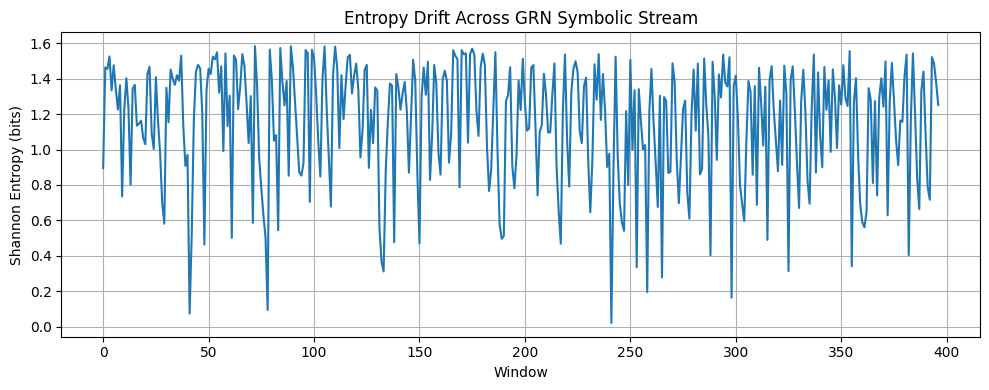

Entropy drift plot saved to: /content/drive/MyDrive/SRL_Phase2_Biological/results/grn_entropy_drift.png


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import glob
import os
from scipy.stats import entropy

# Set working path
data_dir = "/content/drive/MyDrive/SRL_Phase2_Biological/data"
symbol_output = "/content/drive/MyDrive/SRL_Phase2_Biological/symbols/grn_symbolic_stream.npy"
entropy_plot_path = "/content/drive/MyDrive/SRL_Phase2_Biological/results/grn_entropy_drift.png"

# Ensure output directories exist
os.makedirs(os.path.dirname(symbol_output), exist_ok=True)
os.makedirs(os.path.dirname(entropy_plot_path), exist_ok=True)

# Step 1: Load all .txt.gz expression files
files = sorted(glob.glob(data_dir + "/*.txt.gz"))
print(f"Found {len(files)} expression files.")

# Step 2: Load and combine into a single DataFrame
dfs = []
for file in files:
    with gzip.open(file, 'rt') as f:
        df = pd.read_csv(f, sep='\t', index_col=0)
        dfs.append(df)

combined = pd.concat(dfs, axis=1)
combined = combined.fillna(0)

# Step 3: Select top 100 most variable genes
top_genes = combined.var(axis=1).sort_values(ascending=False).head(100).index
symbol_stream = []

# Step 4: Symbolic encoding (fixed for flat-expression genes)
for gene in top_genes:
    values = combined.loc[gene].values
    if np.std(values) == 0:
        continue  # skip genes with no variance
    try:
        bins = pd.qcut(values, q=3, labels=["A", "B", "H"], duplicates='drop')
        symbol_stream.extend(bins.astype(str).tolist())
    except ValueError:
        continue  # skip if qcut still fails

# Step 5: Save symbolic stream
symbol_array = np.array(symbol_stream)
np.save(symbol_output, symbol_array)
print(f"Saved symbolic stream with {len(symbol_array)} entries to {symbol_output}")

# Step 6: Entropy drift visualization
window_size = 500
entropies = []

for i in range(0, len(symbol_array) - window_size, window_size):
    window = symbol_array[i:i + window_size]
    counts = pd.Series(window).value_counts()
    probs = counts / counts.sum()
    entropies.append(entropy(probs, base=2))

plt.figure(figsize=(10, 4))
plt.plot(entropies)
plt.title("Entropy Drift Across GRN Symbolic Stream")
plt.xlabel("Window")
plt.ylabel("Shannon Entropy (bits)")
plt.grid(True)
plt.tight_layout()
plt.savefig(entropy_plot_path)
plt.show()

print(f"Entropy drift plot saved to: {entropy_plot_path}")

In [6]:
import numpy as np
from collections import Counter
import os

# Load the symbolic stream
symbol_path = "/content/drive/MyDrive/SRL_Phase2_Biological/symbols/grn_symbolic_stream.npy"
symbol_array = np.load(symbol_path)
symbol_str = ''.join(symbol_array)

# Loop detection (length-6 repeated motifs)
def find_loops(s, motif="AAAAAA"):
    return s.count(motif)

# Count all unique loops of length 6
loop_length = 6
all_loops = [symbol_str[i:i+loop_length] for i in range(len(symbol_str)-loop_length)]
loop_counts = Counter(all_loops)
top_loops = loop_counts.most_common(10)

# Lempel-Ziv Complexity (naive implementation)
def lz_complexity(s):
    i, k, l = 0, 1, 1
    complexity = 1
    while True:
        if s[i:i+l] == s[k:k+l]:
            l += 1
            if k + l > len(s):
                break
        else:
            complexity += 1
            i = k
            k += 1
            l = 1
        if k >= len(s):
            break
    return complexity / len(s)

lz_score = lz_complexity(symbol_str)

# Output results
results_path = "/content/drive/MyDrive/SRL_Phase2_Biological/results/grn_loop_lzc_results.txt"
os.makedirs(os.path.dirname(results_path), exist_ok=True)
with open(results_path, "w") as f:
    f.write(f"Lempel-Ziv Complexity (normalized): {lz_score:.5f}\\n")
    f.write("Top 10 Symbolic Loops (length=6):\\n")
    for loop, count in top_loops:
        f.write(f"{loop}: {count}\\n")

print(f"Lempel-Ziv Complexity (normalized): {lz_score:.5f}")
print("Top 10 Symbolic Loops:")
for loop, count in top_loops:
    print(f"{loop}: {count}")
print(f"Results saved to: {results_path}")

Lempel-Ziv Complexity (normalized): 0.99998
Top 10 Symbolic Loops:
HHHHHH: 23752
AAAAAA: 19630
AAABAA: 4134
BAAAAA: 4126
AABAAA: 4107
ABAAAA: 4105
AAAAAB: 4104
AAAABA: 4053
HHHHHB: 1697
HHHBHH: 1687
Results saved to: /content/drive/MyDrive/SRL_Phase2_Biological/results/grn_loop_lzc_results.txt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


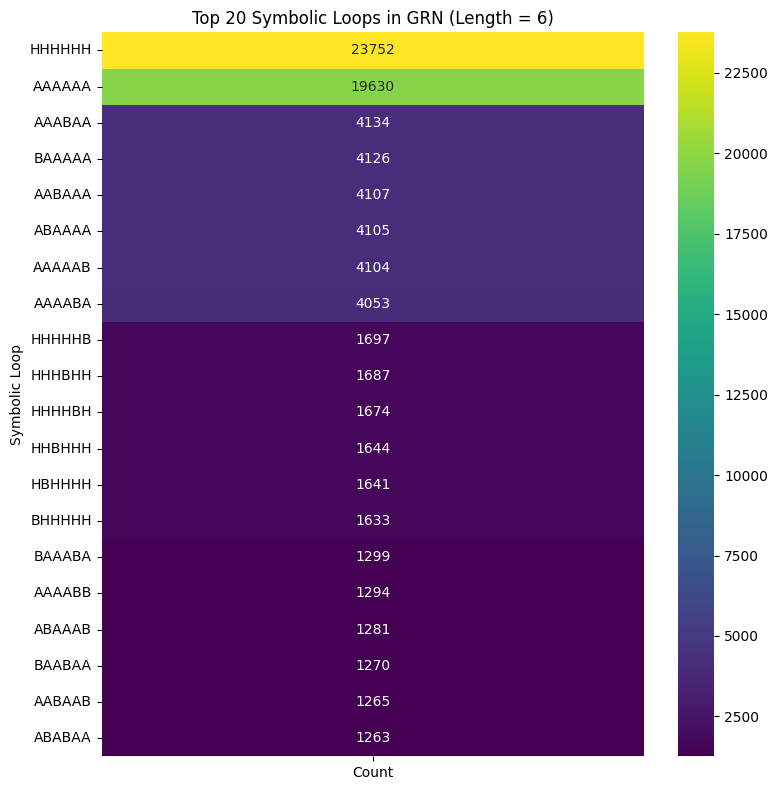

Heatmap saved to: /content/drive/MyDrive/SRL_Phase2_Biological/results/grn_loop_heatmap.png


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import os

# Mount Google Drive again if needed
from google.colab import drive
drive.mount('/content/drive')

# Define paths
symbol_path = "/content/drive/MyDrive/SRL_Phase2_Biological/symbols/grn_symbolic_stream.npy"
fig_path = "/content/drive/MyDrive/SRL_Phase2_Biological/results/grn_loop_heatmap.png"
os.makedirs(os.path.dirname(fig_path), exist_ok=True)

# Load symbolic stream
symbol_array = np.load(symbol_path)
symbol_str = ''.join(symbol_array)

# Extract and count all loops of length 6
loop_length = 6
all_loops = [symbol_str[i:i+loop_length] for i in range(len(symbol_str)-loop_length)]
loop_counts = Counter(all_loops)
top_loops = loop_counts.most_common(20)

# Prepare data for heatmap
motifs = [loop for loop, _ in top_loops]
counts = [count for _, count in top_loops]
heat_data = np.array(counts).reshape(-1, 1)

# Plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(heat_data, annot=True, fmt="d", cmap="viridis",
            yticklabels=motifs, xticklabels=["Count"])
plt.title("Top 20 Symbolic Loops in GRN (Length = 6)")
plt.ylabel("Symbolic Loop")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

print(f"Heatmap saved to: {fig_path}")